In [1]:
%%HTML
<!-- Mejorar visualización en proyector -->
<style>
.rendered_html {font-size: 1.2em; line-height: 150%;}
div.prompt {min-width: 0ex; padding: 0px;}
.container {width:95% !important;}
</style>

In [2]:
%matplotlib notebook
#%autosave 0
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
import torch
import pyro
print(pyro.__version__)

1.0.0


# Non-parametric Bayesian Methods

Before training a neural network we have to select the number of layers and the number of neurons per layer

> The structure of the neural network is fixed

In contrast non-parametric models have no fixed structure

> Non-parametric models automatically infer a model size from the complexity of the data



# Gaussian Process (GP)

Consider our classical linear regression problem 
$$
\begin{align}
Y &= f_\theta(x) + \epsilon \nonumber \\
&= \Phi(x) \theta + \epsilon \nonumber
\end{align}
$$
where we want to find $\theta$ that best fit $Y$

We may consider a Gaussian prior for $\theta$
$$
p(\theta) = \mathcal{N}(0, I \sigma_\theta^2)
$$
hence the distribution of $f_\theta$ is
$$
p(f) = \mathcal{N}(0, K)
$$

because the expected value of $f_\theta$ is zero and the covariance is
$$
\text{cov}(f_\theta) = \mathbb{E}[ \Phi(x)\theta \theta^T \Phi(x)^T] = \sigma_\theta^2 \Phi \Phi^T = K
$$

> The prior over $f$ is called a Gaussian Process (GP)

A GP is a distribution over functions

The GP is parametrized by its covariance aka the kernel or gram matrix

$$
K = \begin{pmatrix} 
\kappa(x_1, x_1)& \kappa(x_1, x_2)& \ldots & \kappa(x_1, x_N) \\
\kappa(x_2, x_1)& \kappa(x_2, x_2)& \ldots & \kappa(x_2, x_N) \\
\vdots& \vdots& \ddots & \vdots \\
\kappa(x_N, x_1)& \kappa(x_N, x_2)& \ldots & \kappa(x_N, x_N) \\
\end{pmatrix}
$$

which by definition is symmetric and positive definite

> The kernel function $\kappa$ controls the similarity between points

We can encode different properties in the kernel (trends, locality, periodicity)

The most broadly used kernel is the Gaussian kernel

$$
\kappa(x, z) = \sigma^2 \exp \left ( \frac{\|x - z \|^2}{2\ell^2} \right)
$$

with parameter $\sigma$ that controls the amplitude and $\ell$ which controls the length-scale of the interactions

> The linear regression has a fixed number of parameters $\theta$ (and basis functions, the GP is the limit with infinite basis functions 

## Inference with GP

If we assume that $\epsilon$ is white Gaussian noise then we can get the distribution of $y$

$$
p(y) = \int p(y|f) p(f) = \mathcal{N}(0, K + I \sigma_\epsilon^2)
$$

Let's say we have $(x,y)$ training data points and we want to predict the output for $x^*$

We can write

$$
\begin{pmatrix}y\\f^*\end{pmatrix} \sim \mathcal{N}  ( 0, \begin{pmatrix}  K_{xx}+I\sigma_\epsilon^2 & K_{xx*} \\ K_{xx*} & K_{x*x*} \end{pmatrix})
$$

Using a bit of algebra we can write the posterior

$$
\begin{align}
p(f^*|y) = \mathcal{N}(&K_{xx*} (K_{xx}+I\sigma_\epsilon^2)^{-1} y, \nonumber \\
& K_{x*x*} - K_{xx*} (K_{xx}+I\sigma_\epsilon^2)^{-1} K_{xx*}^T ) 
\end{align}
$$

Which we can fit by maximizing the marginal log likelihood 
$$
\log p(y|x) = \log \int p(y | f, x) p(f) df
$$ 
using for example gradient descent

#### Details
- The mean of the GP can be a function 
- 

## GP with pyro

Let's start by creating some synthetic data for regression

<IPython.core.display.Javascript object>


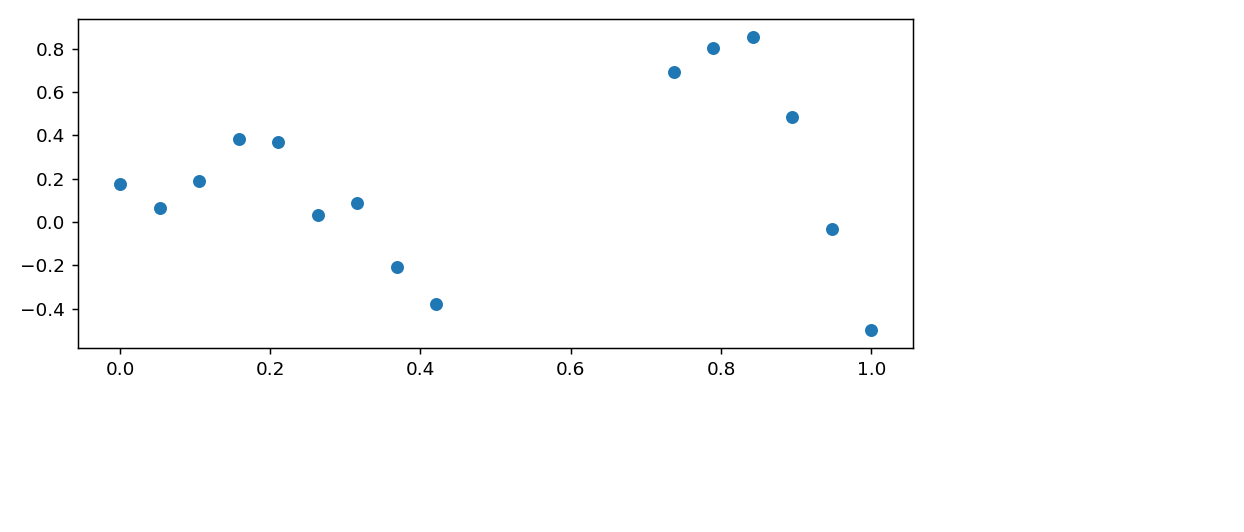

In [57]:
# Synthetic data
se = 0.1
np.random.seed(0)
x = np.linspace(0, 1, num=20) #100x1
x_test = np.linspace(-0.4, 1.6, num=200).astype('float32')
f = lambda x : x*np.sin(10*x)

x = np.delete(x, slice(9, 14))
y = f(x) + se*np.random.randn(len(x))
fig, ax = plt.subplots(figsize=(7, 3), tight_layout=True)
ax.scatter(x, y);

x_torch = torch.from_numpy(x.astype('float32'))
y_torch = torch.from_numpy(y.astype('float32'))

We will use [`pyro.contrib.gp`](http://docs.pyro.ai/en/stable/contrib.gp.html) to implement our first GP

Let's start by creating a kernel from `gp.kernels`

We will use a Radial Basis Function (RBF) aka Squared Exponential aka Gaussian kernel as our covariance

We can specify the initial value of the variance and the lengthscale

In [31]:
import pyro.contrib.gp as gp

pyro.enable_validation(True)
pyro.set_rng_seed(0)

K = gp.kernels.RBF(input_dim=1, 
                   variance=torch.tensor(1.), 
                   lengthscale=torch.tensor(0.1))

How does this model looks before fitting the data? 

Let's inspect the prior $\mathcal{N}(0, K)$ on the test data

**Activity:** Increase/decrese the lengthscale and repeat, get a notion of its influence

<IPython.core.display.Javascript object>


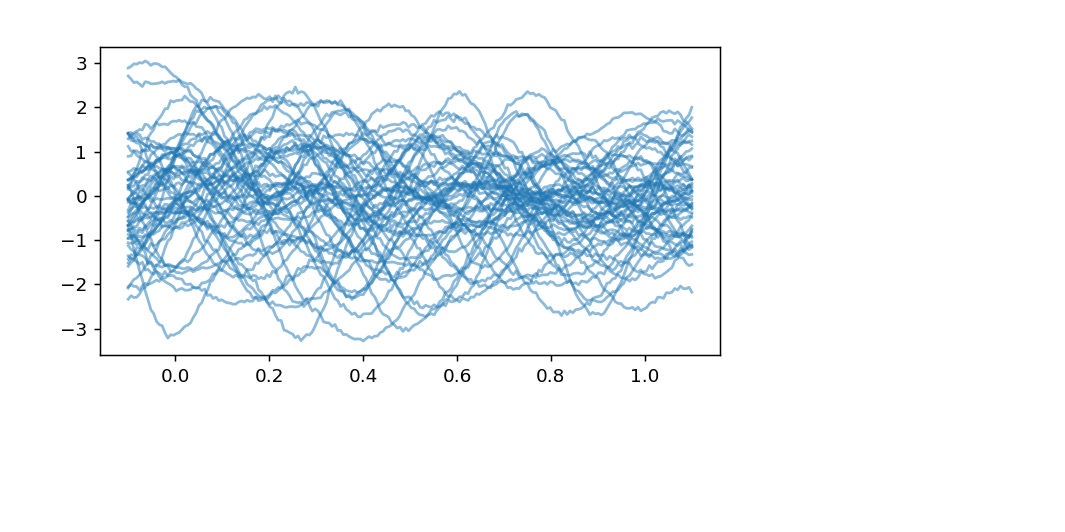

In [32]:
# We sum a small value to the diagonal for numerical stability
C = K.forward(torch.from_numpy(x_test)) + torch.eye(len(x_test))*1e-3
# Then we sample from the a multivariate normal distribution
samples = pyro.distributions.MultivariateNormal(torch.zeros(len(x_test)), 
                                                covariance_matrix=C).sample(sample_shape=(50,))
        
fig, ax = plt.subplots(figsize=(6, 3))
for i in range(samples.shape[0]):
    ax.plot(x_test, samples.detach().numpy()[i, :],
            linestyle='-', c='tab:blue', alpha=0.5)

Then we create a model from `gp.models`

> In this case we pick a model for regression `GPRegression`

This model expects the train data, the kernel and the initial value of the noise variance

Then we select an optimizer and a cost function

> We will use Adam and the Trace_ELBO, respectively

Training is very similar to how we train neural networks in pytorch

> The only remarkable difference is that the cost function expects the `model` and `guide` from our GP

To do predictions we use the forward attribute of our `GPRegression` instance

In [34]:
# Helper function to train GP and plot the results

def train_gp_plots(model, x, y, x_test, nepochs=2000):
    fig, ax = plt.subplots(1, 2, figsize=(7, 3), tight_layout=True)
    line_loss = ax[1].plot([], [])
    ax[0].scatter(x, y)
    epoch_loss = np.zeros(shape=(nepochs,))

    for k in tqdm_notebook(range(len(epoch_loss))):
        optimizer.zero_grad()
        loss = criterion(model.model, model.guide)
        loss.backward()
        optimizer.step()
        epoch_loss[k] = loss.item()
        #break    
        if k % 100 == 0:
            ax[0].cla()
            # Predictions at x_test
            mu, cov = model.forward(x_test, full_cov=True, noiseless=False)
            mu = mu.detach().numpy()
            sd = cov.diag().sqrt().detach().numpy()        
            ax[0].scatter(x, y, c='k')
            ax[0].plot(x_test.detach(), mu)
            ax[0].fill_between(x_test.detach(), mu-2*sd, mu+2*sd, alpha=0.5)
            line_loss[0].set_xdata(range(k))
            line_loss[0].set_ydata(epoch_loss[:k])
            ax[1].relim()
            ax[1].autoscale_view()
            fig.canvas.draw()

<IPython.core.display.Javascript object>


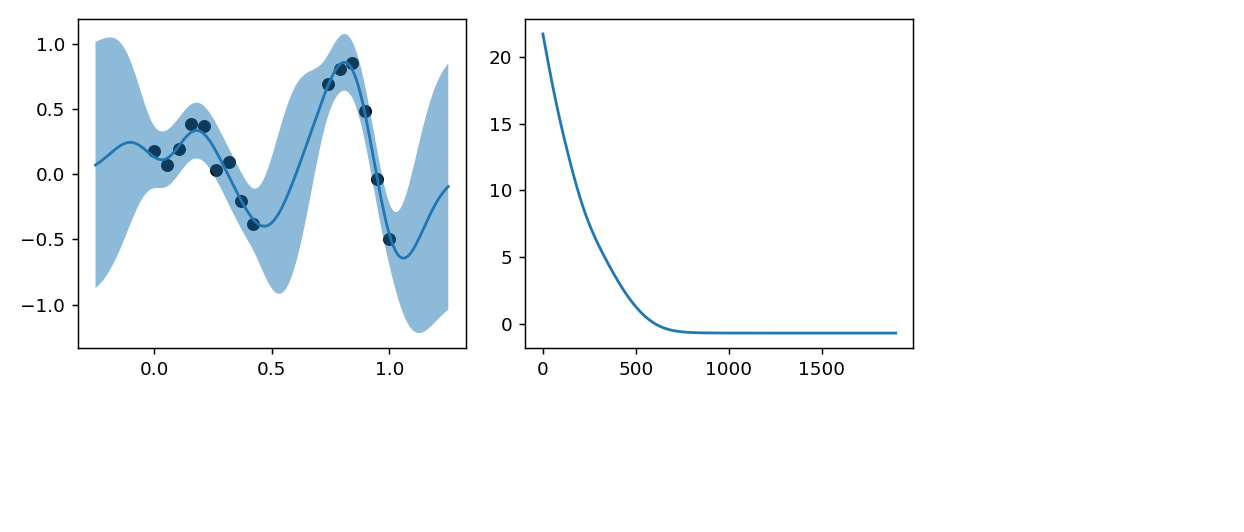

In [41]:
pyro.clear_param_store()

#Kernel
K = gp.kernels.RBF(input_dim=1, 
                   variance=torch.tensor(1.0), 
                   lengthscale=torch.tensor(0.1))
# Model
gpr_model = gp.models.GPRegression(x_torch, y_torch, # Training data
                                   mean_function=None, # Mean
                                   kernel=K, # Covarianze
                                   jitter=1e-6, # Increase this if you have numerical problems 
                                   noise=torch.tensor(2.) # The variance of the white noise
                                   )
# Optimizer
optimizer = torch.optim.Adam(gpr_model.parameters(), lr=1e-2)
# Criterion
criterion = pyro.infer.Trace_ELBO().differentiable_loss

train_gp_plots(gpr_model, x, y, torch.from_numpy(x_test))

The learned parameters are

In [42]:
display("RBF variance:", gpr_model.kernel.variance.item())
display("RBF length scale:", gpr_model.kernel.lengthscale.item())
display("Noise variance:", gpr_model.noise.item())

'RBF variance:'

0.21953055262565613

'RBF length scale:'

0.11527466773986816

'Noise variance:'

0.00786062516272068

We can also sample from the posterior

<IPython.core.display.Javascript object>


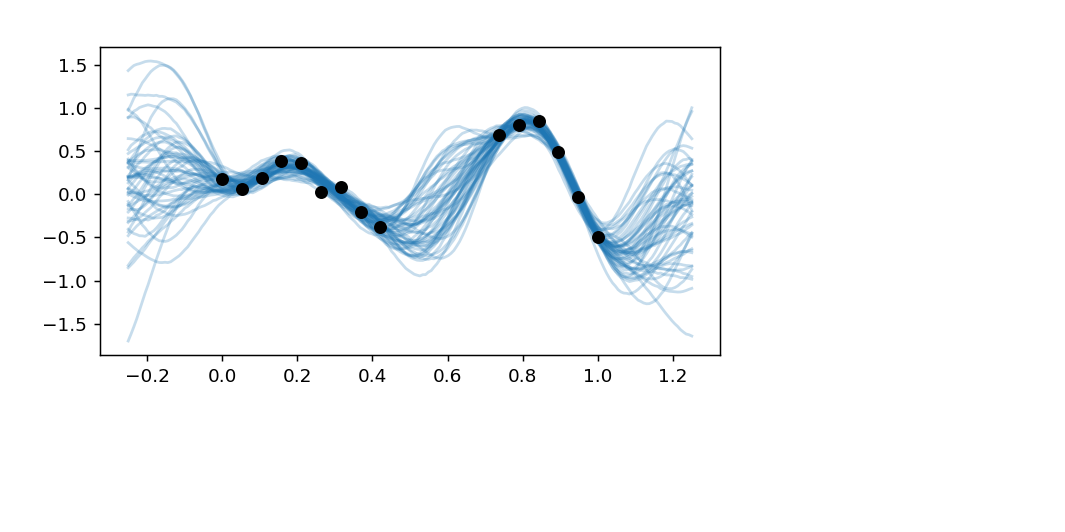

In [43]:
# We sum a small value to the diagonal for numerical stability
mu, Sigma = gpr_model.forward(torch.from_numpy(x_test), full_cov=True, noiseless=True)
Sigma += torch.eye(len(x_test))*1e-5
# Then we sample from the a multivariate normal distribution
samples = pyro.distributions.MultivariateNormal(mu, covariance_matrix=Sigma).sample(sample_shape=(50,))
        
fig, ax = plt.subplots(figsize=(6, 3))
for i in range(samples.shape[0]):
    ax.plot(x_test, samples.detach().numpy()[i, :], 
            linestyle='-', c='tab:blue', alpha=0.25)
ax.scatter(x, y, c='k', zorder=100);

### Trying different kernels

Kernel are implemented in [pyro.contrib.gp.kernels](http://docs.pyro.ai/en/stable/contrib.gp.html#module-pyro.contrib.gp.kernels)

Compare the RBF and Matern52 kernels. What differences do you observe?

<IPython.core.display.Javascript object>


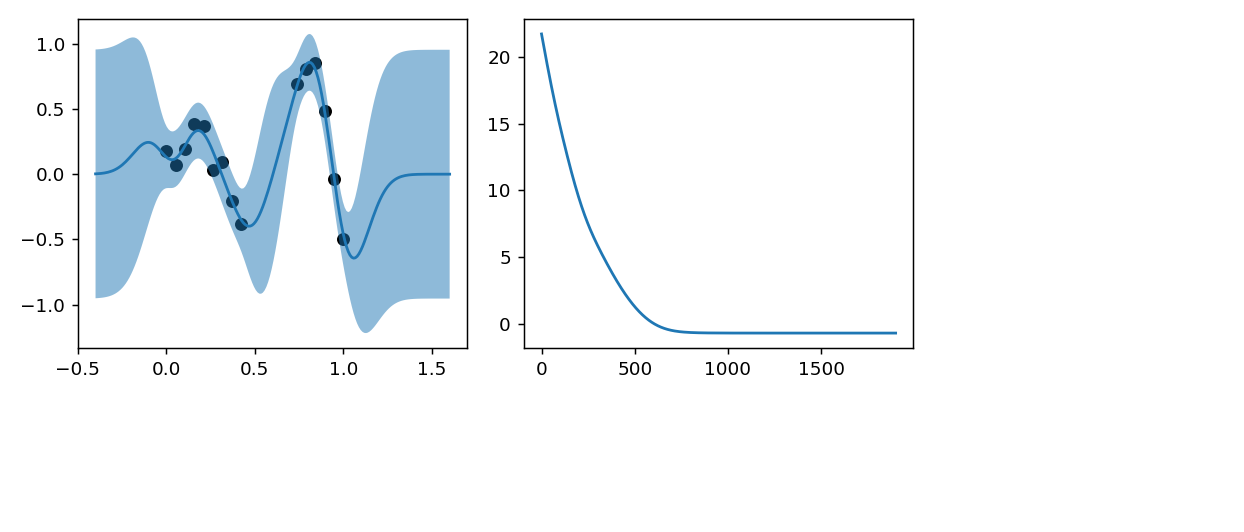

In [50]:
pyro.clear_param_store()

#Kernel
K = gp.kernels.RBF(input_dim=1, variance=torch.tensor(1.0), lengthscale=torch.tensor(0.1))
#K = gp.kernels.Matern52(input_dim=1, variance=torch.tensor(1.0), lengthscale=torch.tensor(0.1))
#K = gp.kernels.Periodic(input_dim=1, variance=torch.tensor(2.0), lengthscale=torch.tensor(0.1), period=torch.tensor(0.5))
# Model
gpr_model = gp.models.GPRegression(x_torch, y_torch, 
                                   kernel=K, 
                                   noise=torch.tensor(2.))
# Optimizer
optimizer = torch.optim.Adam(gpr_model.parameters(), lr=1e-2)
# Criterion
criterion = pyro.infer.Trace_ELBO().differentiable_loss
# Train and plot
train_gp_plots(gpr_model, x, y, torch.from_numpy(x_test))

### Setting priors for the parameters 

Before we did an MLE like estimation to find point estimates of the kernel parameters and the noise variance

We can treat these parameters as random variables and set priors for them

Training with these priors is equivalent to the MAP solution

<IPython.core.display.Javascript object>


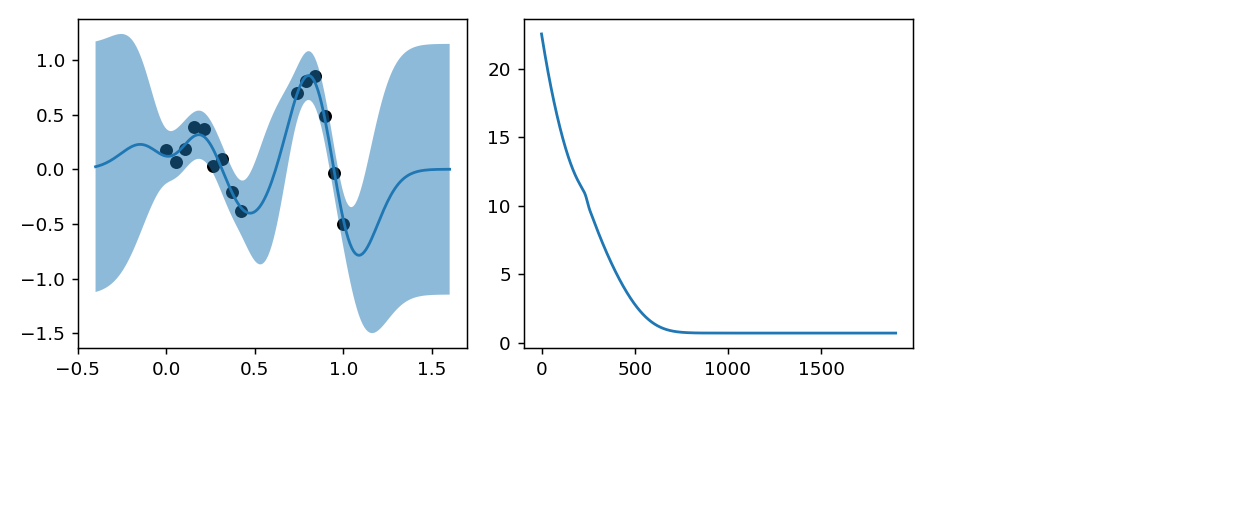

In [58]:
pyro.clear_param_store()
from pyro.distributions import LogNormal

#Kernel
K = gp.kernels.RBF(input_dim=1, variance=torch.tensor(1.0), lengthscale=torch.tensor(0.1))
# Model
gpr_model_prior = gp.models.GPRegression(x_torch, y_torch, 
                                   kernel=K, 
                                   noise=torch.tensor(2.))

# Setting priors
gpr_model_prior.kernel.lengthscale = pyro.nn.PyroSample(LogNormal(0.0, 1.0))
gpr_model_prior.kernel.variance = pyro.nn.PyroSample(LogNormal(0.0, 1.0))

# Optimizer
optimizer = torch.optim.Adam(gpr_model_prior.parameters(), lr=1e-2)
# Criterion
criterion = pyro.infer.Trace_ELBO().differentiable_loss
# Train and plot    
train_gp_plots(gpr_model_prior, x, y, torch.from_numpy(x_test))

# Combining kernels

Summing or multiplying valid kernels yield a valid kernel

> We can easily create new kernels from other kernels

Take advantage of the different properties of kernels

#### Example

The following data has a periodic oscilation on a rising trend

Try to fit it using `K1`, `K2`, `Ksum12` and `Kprod12`

Can you explain in simple words your results?

<IPython.core.display.Javascript object>


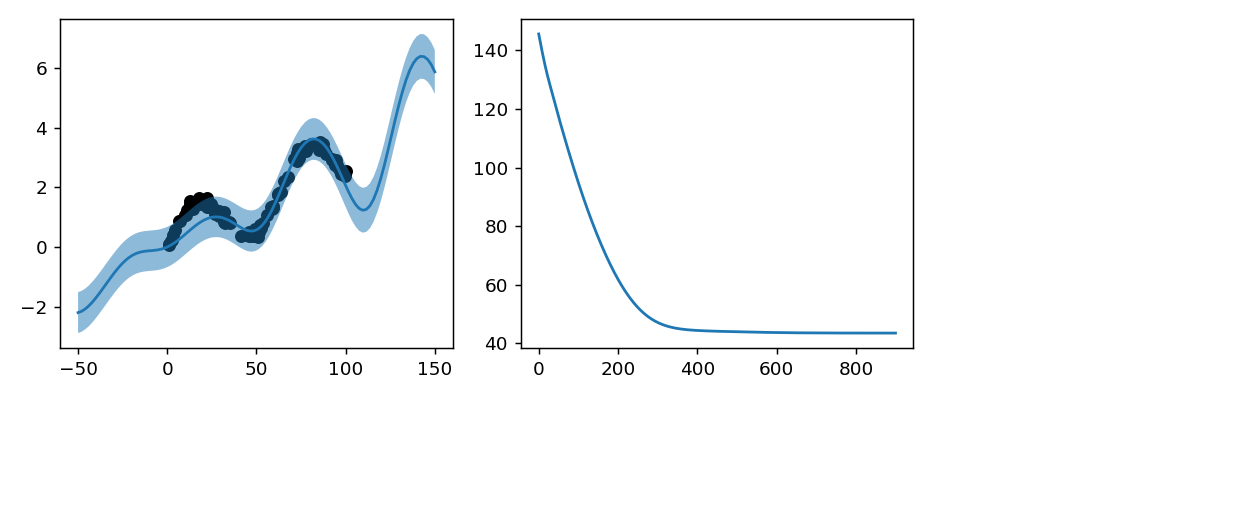

In [55]:
x = np.random.rand(100).astype('float32')*100
y = (0.03*x + np.sin(0.1*x) + 0.1*np.random.randn(100)).astype('float32')

pyro.clear_param_store()

K1 = gp.kernels.Periodic(input_dim=1, variance=torch.tensor(1.), 
                        lengthscale=torch.tensor(10),
                        period=torch.tensor(50))
K2 = gp.kernels.Linear(input_dim=1, variance=torch.tensor(1.))
Ksum12 = gp.kernels.Sum(K1, K2)
Kprod12 = gp.kernels.Product(K1, K2)

# Model
gpr_model = gp.models.GPRegression(torch.from_numpy(x), torch.from_numpy(y), 
                                   kernel=Kprod12, noise=torch.tensor(2.))

optimizer = torch.optim.Adam(gpr_model.parameters(), lr=1e-2)
criterion = pyro.infer.Trace_ELBO().differentiable_loss
train_gp_plots(gpr_model, x, y, torch.linspace(-50, 150, 100), nepochs=1000)

## Sparse Gaussian Processes

Fitting a Gaussian process has cubic complexity

Sparse Gaussian processes use a much smaller set of "inducing points" to compute the kernel

<IPython.core.display.Javascript object>


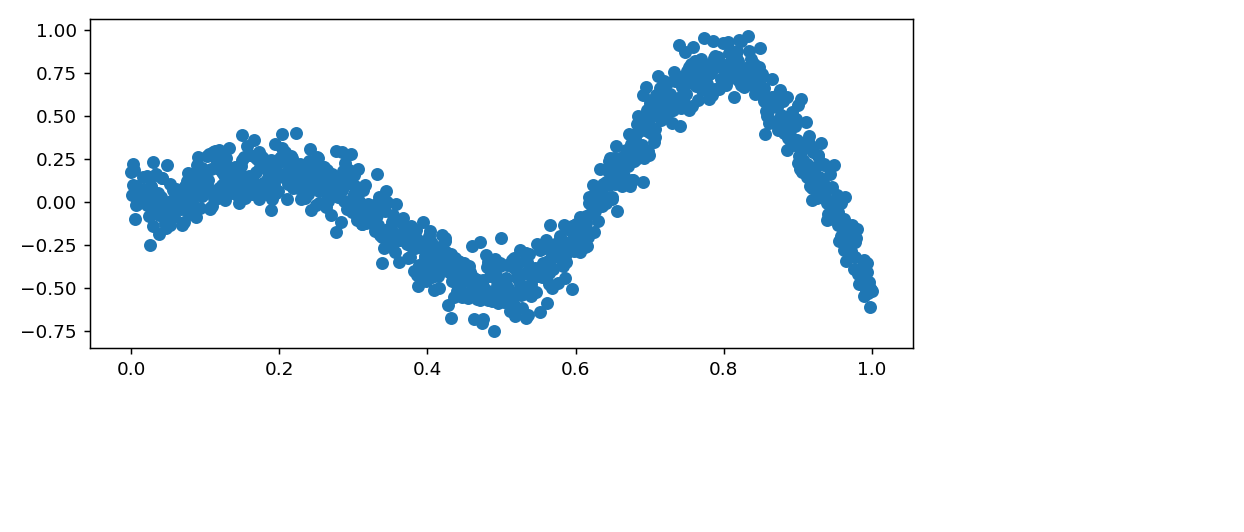

In [59]:
# Synthetic data
se = 0.1
np.random.seed(0)
x = np.linspace(0, 1, num=1000) #100x1
x_test = np.linspace(-0.1, 1.1, num=200).astype('float32')
f = lambda x : x*np.sin(10*x)

x = np.delete(x, slice(9, 14))
y = f(x) + se*np.random.randn(len(x))
fig, ax = plt.subplots(figsize=(7, 3), tight_layout=True)
ax.scatter(x, y);

x_torch = torch.from_numpy(x.astype('float32'))
y_torch = torch.from_numpy(y.astype('float32'))

<IPython.core.display.Javascript object>


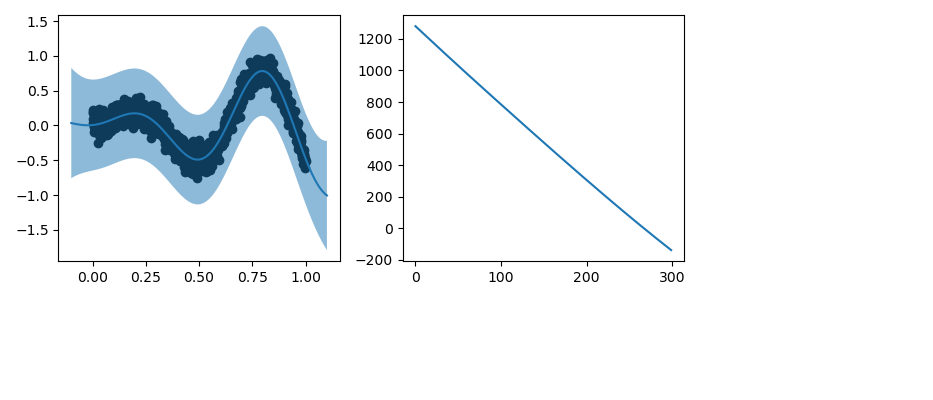

KeyboardInterrupt: 

In [60]:
pyro.clear_param_store()

#Kernel
K = gp.kernels.RBF(input_dim=1, 
                   variance=torch.tensor(1.0), 
                   lengthscale=torch.tensor(0.1))
# Model
gpr_model = gp.models.GPRegression(x_torch, y_torch, 
                                   kernel=K, 
                                   noise=torch.tensor(2.))
# Optimizer
optimizer = torch.optim.Adam(gpr_model.parameters(), lr=1e-2)
# Criterion
criterion = pyro.infer.Trace_ELBO().differentiable_loss

train_gp_plots(gpr_model, x, y, torch.from_numpy(x_test))

<IPython.core.display.Javascript object>


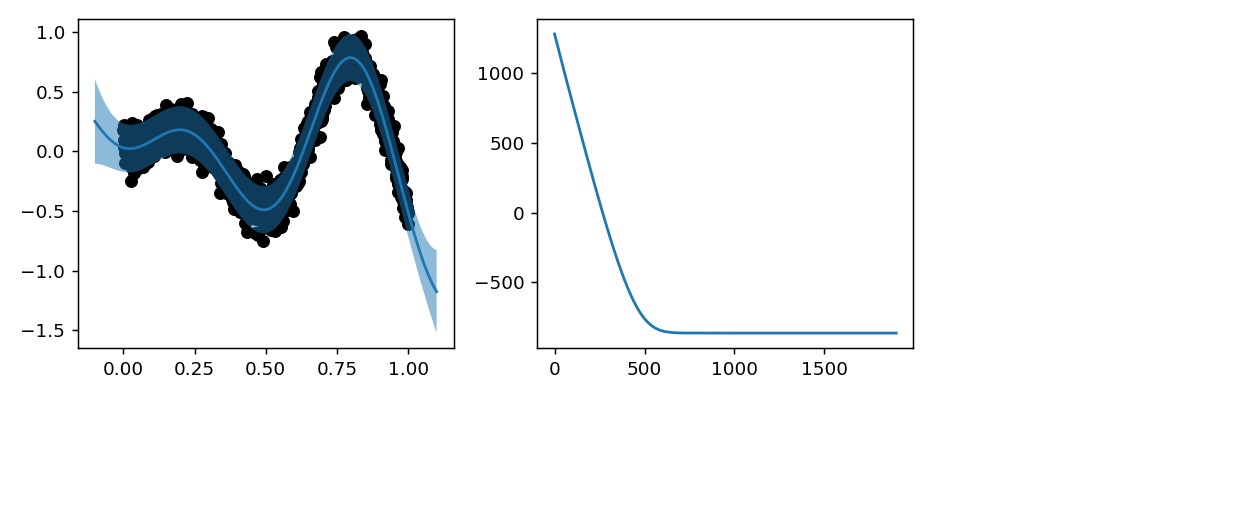

In [61]:
pyro.clear_param_store()

#Kernel
K = gp.kernels.RBF(input_dim=1, 
                   variance=torch.tensor(1.0), 
                   lengthscale=torch.tensor(0.1))
# Model
gpr_model = gp.models.SparseGPRegression(x_torch, y_torch, approx='VFE',
                                         kernel=K, Xu=torch.linspace(0, 1, 20),
                                         noise=torch.tensor(2.), jitter=1e-5)
# Optimizer
optimizer = torch.optim.Adam(gpr_model.parameters(), lr=1e-2)
# Criterion
criterion = pyro.infer.Trace_ELBO().differentiable_loss

train_gp_plots(gpr_model, x, y, torch.from_numpy(x_test))

## Multi-task GP and Coregionalization

**PENDING**

In some cases we might need to perform regression on vector valued data (more than one feature)

We might also expect some degree of correlation between the features

We train a multi-task GP and learn the correlation between features with a [coregionalized kernel](http://docs.pyro.ai/en/stable/contrib.gp.html#pyro.contrib.gp.kernels.Coregionalize)

A coregionalization kernel is defined as a matrix
$$
B = W W^T + I \delta
$$
where $W$ models correlations between features

<IPython.core.display.Javascript object>


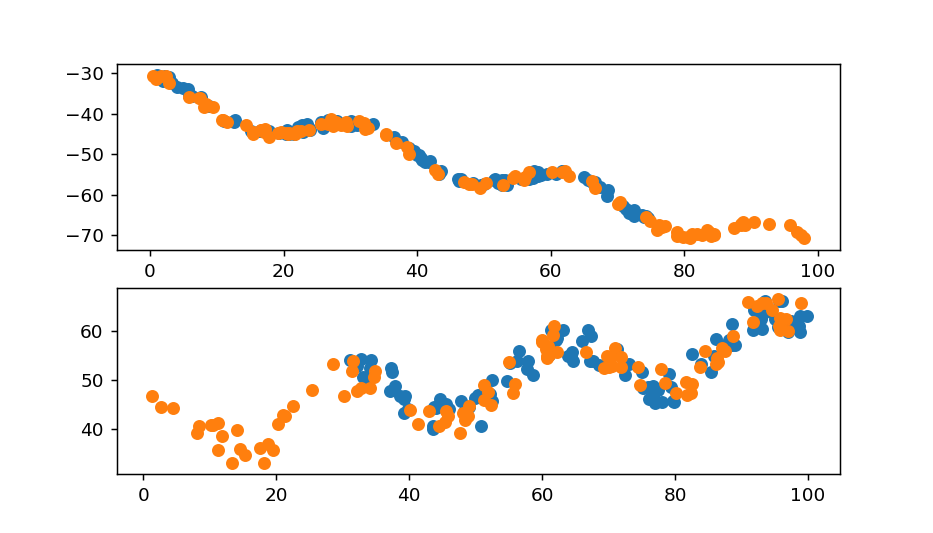

In [62]:
f_output1 = lambda x: 4. * np.cos(x/5.) - .4*x - 35. + np.random.rand(x.size) * 2.
f_output2 = lambda x: 6. * np.cos(x/5.) + .2*x + 35. + np.random.rand(x.size) * 8.

#{X,Y} training set for each output
X1 = np.random.rand(100).astype('float32'); X1=X1*75
X2 = np.random.rand(100).astype('float32'); X2=X2*70 + 30
Y1 = f_output1(X1).astype('float32')
Y2 = f_output2(X2).astype('float32')
#{X,Y} test set for each output
Xt1 = np.random.rand(100).astype('float32')*100
Xt2 = np.random.rand(100).astype('float32')*100
Yt1 = f_output1(Xt1).astype('float32')
Yt2 = f_output2(Xt2).astype('float32')

fig, ax = plt.subplots(2, 1, figsize=(7, 4))
ax[0].scatter(X1, Y1)
ax[0].scatter(Xt1, Yt1)
ax[1].scatter(X2, Y2)
ax[1].scatter(Xt2, Yt2);

In [ ]:
pyro.clear_param_store()

K1 = gp.kernels.RBF(input_dim=1, 
                   variance=torch.tensor(1.0), 
                   lengthscale=torch.tensor(0.1))
gpr_model1 = gp.models.GPRegression(torch.from_numpy(X1), torch.from_numpy(Y1), 
                                   kernel=K1, 
                                   noise=torch.tensor(2.))


optimizer = torch.optim.Adam(gpr_model1.parameters(), lr=1e-2)
criterion = pyro.infer.Trace_ELBO().differentiable_loss
train_gp_plots(gpr_model1, X1, Y1, torch.from_numpy(np.sort(Xt1)))

In [ ]:
pyro.clear_param_store()
K2 = gp.kernels.RBF(input_dim=1, 
                   variance=torch.tensor(1.0), 
                   lengthscale=torch.tensor(0.1))
gpr_model2 = gp.models.GPRegression(torch.from_numpy(X2), torch.from_numpy(Y2), 
                                   kernel=K2, 
                                   noise=torch.tensor(2.))

criterion = pyro.infer.Trace_ELBO().differentiable_loss
optimizer = torch.optim.Adam(gpr_model2.parameters(), lr=1e-2)
train_gp_plots(gpr_model2, X2, Y2, torch.from_numpy(np.sort(Xt2)))

### Deep Gaussian Processes

Stacks of Gaussian Processes

Example in Pyro: https://fehiepsi.github.io/blog/deep-gaussian-process/

# GPyTorch

https://gpytorch.ai/

# Self-study

- Mackay chapter 45
- Barber chapter 19
- [Rasmussen & Willams, "Gaussian Process for Machine Learning"](http://gaussianprocess.org/gpml/?)
- [Zhoubin Ghahramadi tutorial](http://mlg.eng.cam.ac.uk/zoubin/talks/uai05tutorial-b.pdf)